# K-means Clustering

In [1]:
# import the library
%matplotlib inline

import pandas as pd
import numpy as np
import collections
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics.pairwise import euclidean_distances

# convert scientific notation to decimals
pd.set_option('display.float_format', lambda x: '%.2f' % x)
sns.set_style('whitegrid')

# Problem definition
Clustering flights according to delay reasons.

____________
# Load the Data

### Cleaned, Merged dataset can be downloaded from here: https://www.kaggle.com/arwasheraky/cleaned-flight-delays-2015

In [2]:
df_flights = pd.read_csv('../data/flightsmerged.csv', low_memory=False)
print(df_flights.columns)
df_flights.head()

Index(['MONTH', 'FLIGHT_NUMBER', 'TAIL_NUMBER', 'SCHEDULED_DEPARTURE',
       'DEPARTURE_TIME', 'DEPARTURE_DELAY', 'SCHEDULED_TIME', 'DISTANCE',
       'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY', 'DIVERTED',
       'CANCELLED', 'CANCELLATION_REASON', 'AIR_SYSTEM_DELAY',
       'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY',
       'WEATHER_DELAY', 'DATE', 'CLASS', 'AIRLINE_CODE', 'AIRLINE_NAME',
       'ORIGIN_AC', 'ORIGIN_NAME', 'ORIGIN_STATE', 'ORIGIN_LATITUDE',
       'ORIGIN_LONGITUDE', 'DESTINATION_AC', 'DESTINATION_NAME', 'DEST_STATE',
       'DEST_LATITUDE', 'DEST_LONGITUDE'],
      dtype='object')


,MONTH,FLIGHT_NUMBER,TAIL_NUMBER,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_TIME,DISTANCE,SCHEDULED_ARRIVAL,ARRIVAL_TIME,...,ORIGIN_AC,ORIGIN_NAME,ORIGIN_STATE,ORIGIN_LATITUDE,ORIGIN_LONGITUDE,DESTINATION_AC,DESTINATION_NAME,DEST_STATE,DEST_LATITUDE,DEST_LONGITUDE
0,1,98,N407AS,00:05:00,23:54:00,-11.00,205.00,1448,04:30:00,04:08:00,...,ANC,Ted Stevens Anchorage International Airport,AK,61.17,-150.00,SEA,Seattle-Tacoma International Airport,WA,47.45,-122.31
1,1,2336,N3KUAA,00:10:00,00:02:00,-8.00,280.00,2330,07:50:00,07:41:00,...,LAX,Los Angeles International Airport,CA,33.94,-118.41,PBI,Palm Beach International Airport,FL,26.68,-80.10
2,1,840,N171US,00:20:00,00:18:00,-2.00,286.00,2296,08:06:00,08:11:00,...,SFO,San Francisco International Airport,CA,37.62,-122.37,CLT,Charlotte Douglas International Airport,NC,35.21,-80.94
3,1,258,N3HYAA,00:20:00,00:15:00,-5.00,285.00,2342,08:05:00,07:56:00,...,LAX,Los Angeles International Airport,CA,33.94,-118.41,MIA,Miami International Airport,FL,25.79,-80.29
4,1,135,N527AS,00:25:00,00:24:00,-1.00,235.00,1448,03:20:00,02:59:00,...,SEA,Seattle-Tacoma International Airport,WA,47.45,-122.31,ANC,Ted Stevens Anchorage International Airport,AK,61.17,-150.00


_________________
# Feature Engineering

In [65]:
# Keep just the delayed flights

df = df_flights[df_flights['CLASS'] == 'Delayed']
df = df.drop(columns = ['CANCELLATION_REASON','CANCELLED'])

In [66]:
df = df.dropna()
df.shape

(5109022, 31)

## Add a column

In [67]:
# Average delay column

df['AVG_DELAY'] = (df['DEPARTURE_DELAY'] + df['ARRIVAL_DELAY']) / 2.0
df['AVG_DELAY'].head(10)


0   -16.50
1    -8.50
2     1.50
3    -7.00
4   -11.00
5     1.50
6   -11.50
7     2.00
8   -12.00
9    -6.00
Name: AVG_DELAY, dtype: float64

## Filter the flights

In [69]:
# Remove flights with avg. delay between [-1,1]

flights_to_remove = list(df[(df['AVG_DELAY'] > -1) & (df['AVG_DELAY'] < 1)].index)
new_df = df[~df.index.isin(flights_to_remove)]
new_df.shape

(4891239, 32)

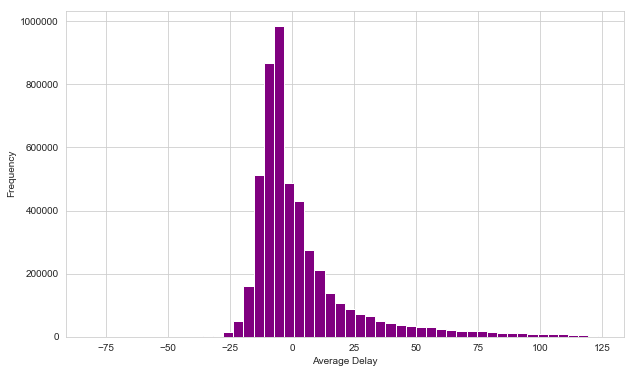

In [70]:
plt.figure(figsize=(10,6))
plt.hist(new_df['AVG_DELAY'], bins=50, color='purple')
plt.xlabel("Average Delay")
plt.ylabel("Frequency")
plt.show()

## Select Model Columns

In [71]:
# Select delay reasons columns

delay_reason = new_df[['AIR_SYSTEM_DELAY','SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY','WEATHER_DELAY']]
delay_reason.mean()

AIR_SYSTEM_DELAY      2.08
SECURITY_DELAY        0.01
AIRLINE_DELAY         2.26
LATE_AIRCRAFT_DELAY   2.96
WEATHER_DELAY         0.28
dtype: float64

In [72]:
X_columns = ['AVG_DELAY'] + list(delay_reason.columns)

In [73]:
# normalize the columns
df_norm = new_df.copy()
df_norm = df_norm[X_columns]

for col in X_columns:
    df_norm[col] = new_df[col].astype(float)
    df_norm[col] = StandardScaler().fit_transform(df_norm[col].values.reshape(-1, 1))

df_norm.head()


,AVG_DELAY,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,-0.91,-0.23,-0.02,-0.23,-0.25,-0.08
1,-0.54,-0.23,-0.02,-0.23,-0.25,-0.08
2,-0.08,-0.23,-0.02,-0.23,-0.25,-0.08
3,-0.47,-0.23,-0.02,-0.23,-0.25,-0.08
4,-0.66,-0.23,-0.02,-0.23,-0.25,-0.08


_______
# Model Training

In [74]:
k = 5
kmeans = KMeans(n_clusters=k).fit(df_norm.values)

print(set(kmeans.labels_))
print(collections.Counter(kmeans.labels_))

{0, 1, 2, 3, 4}
Counter({0: 4378688, 1: 281242, 2: 210890, 3: 19284, 4: 1135})


In [75]:
df_results = new_df.copy()
df_norm['cluster'] = kmeans.labels_
df_results['cluster'] = kmeans.labels_
df_results = df_results.reset_index()

____________
# Analyze the Results

Cluster 0  : [(469, 3044), (326, 2666), (327, 2566)]
Cluster 1  : [(719, 322), (711, 314), (403, 289)]
Cluster 2  : [(910, 207), (356, 185), (46, 178)]
Cluster 3  : [(55, 27), (407, 24), (1756, 22)]
Cluster 4  : [(161, 17), (61, 9), (223, 7)]
AVG_DELAY


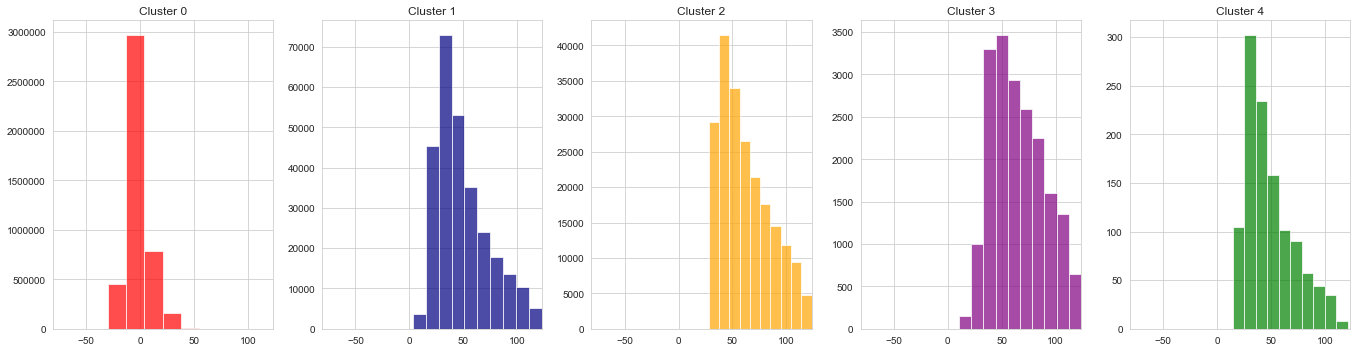

AIR_SYSTEM_DELAY


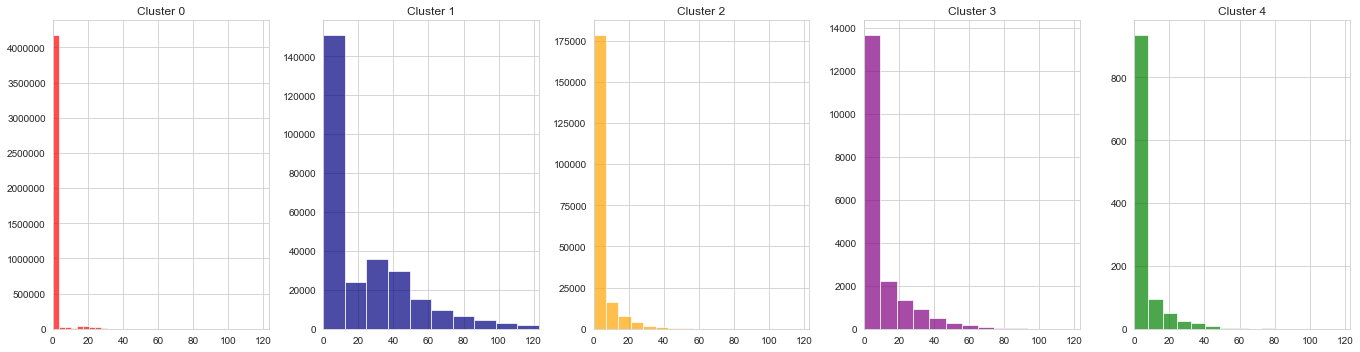

SECURITY_DELAY


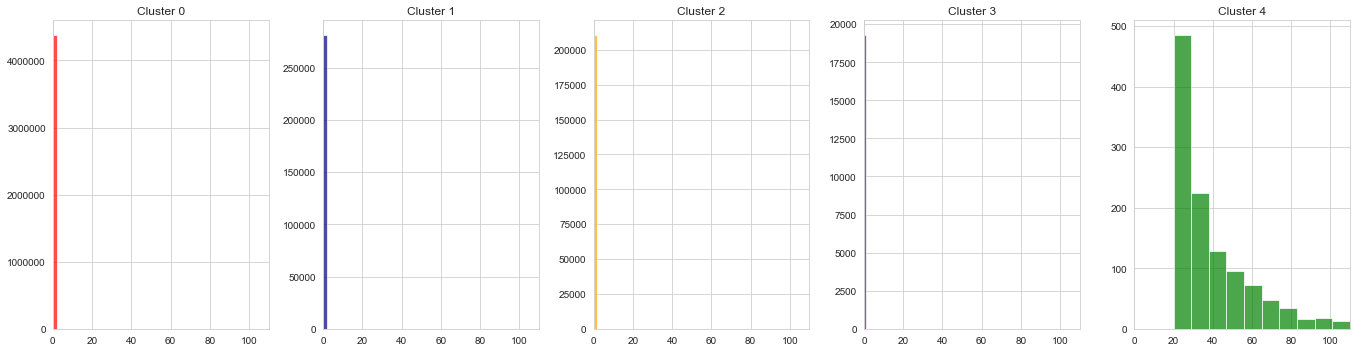

AIRLINE_DELAY


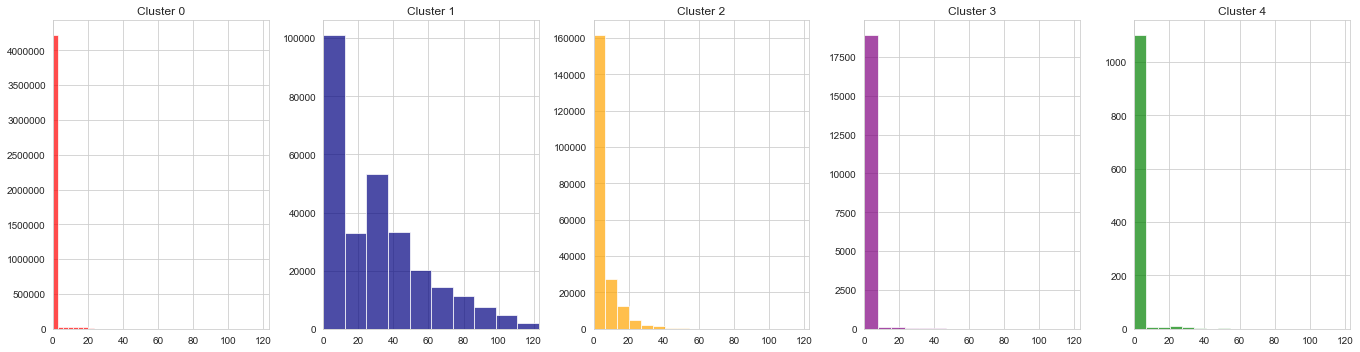

LATE_AIRCRAFT_DELAY


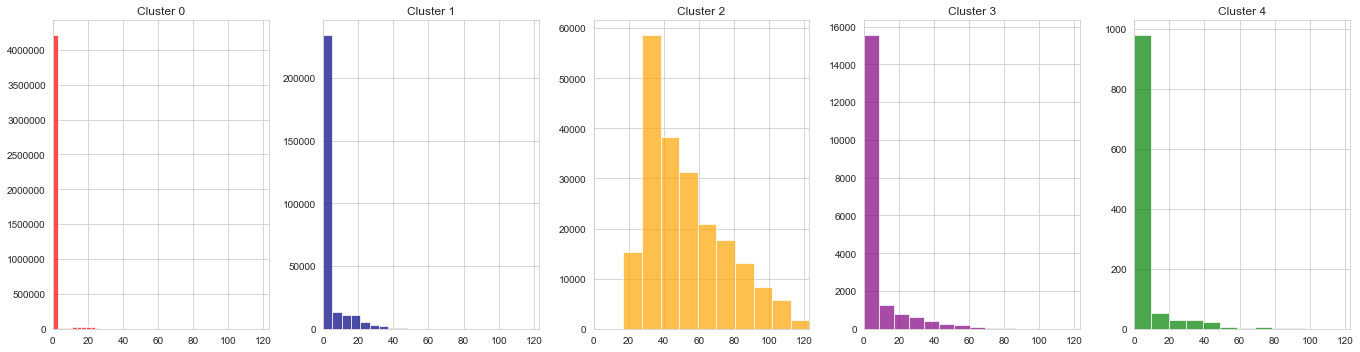

WEATHER_DELAY


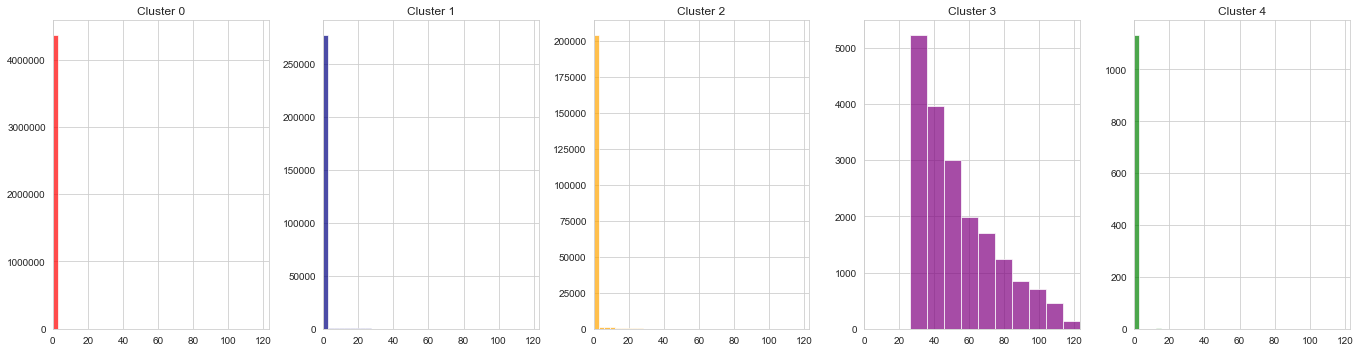

In [76]:
# print the most common flights in each cluster

for cluster in sorted(set(kmeans.labels_)):
    print("Cluster",cluster," :",
          collections.Counter(df_results[df_results['cluster']==cluster]['FLIGHT_NUMBER']).most_common(3))

colors = ['red','navy','orange','purple','green']
n_clusters = len(set(kmeans.labels_))

for col in X_columns:
    print(col)
    i = 1
    plt.figure(figsize=(19,5))
    
    for cluster in sorted(set(kmeans.labels_)):
        plt.subplot(1, n_clusters, i)
        plt.xlim([df_results[col].min(),df_results[col].max()])
        plt.hist(df_results[df_results['cluster']==cluster][col], bins=10, label=str(cluster), alpha=0.7, color=colors[i-1])
        plt.title("Cluster "+str(cluster))
        i += 1
    
    plt.tight_layout()
    plt.show()


#### Conclusions:
- Cluster 0: Flights have the highest delay avg, without specific delay reasons. The most contributing factor in the delay could be `Air System Problems`.
- Cluster 1:  Flights delayed mainly due to `Air System Problems`, and secondly `certain conditions in the Airline`
- Cluster 2: Flights delayed mainly due to `Late Aircraft`
- Cluster 3: Flights delayed mainly due to `Weather Conditions`, and secondly `Air System Problems`.
- Cluster 4: Flights delayed mainly due to `Security Issues`.

AVG_DELAY


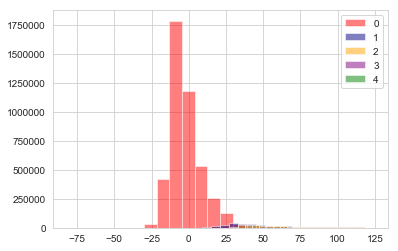

AIR_SYSTEM_DELAY


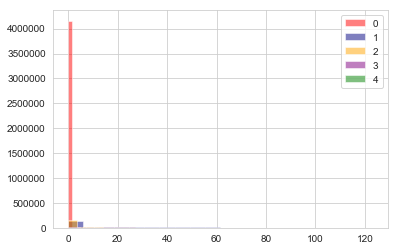

SECURITY_DELAY


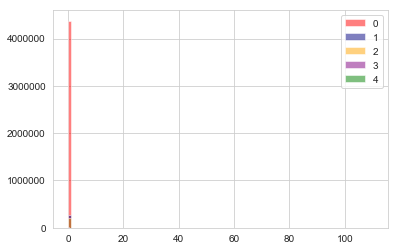

AIRLINE_DELAY


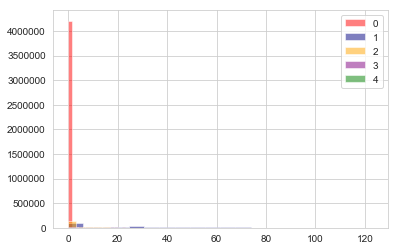

LATE_AIRCRAFT_DELAY


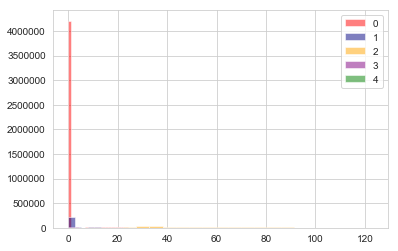

WEATHER_DELAY


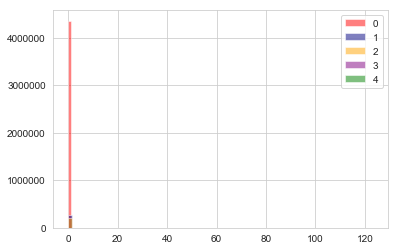

In [78]:
# for col in X_columns:
#     print(col)
#     j = 0

#     for cluster in set(kmeans.labels_):
#         plt.hist(df_results[df_results['cluster']==cluster][col], label="Cluster"+str(cluster), alpha=0.5, bins=20, color=colors[j])
#         j+=1
        
#     plt.legend()
#     plt.show()

___________
# Model Evaluation

In [79]:
# Inter-Cluster

centroids = []
for cluster in sorted(set(kmeans.labels_)):
    centroids.append(df_norm[df_norm['cluster']==cluster][X_columns].mean().values)
    
distances = []
for c1 in centroids:
    for c2 in centroids:
        distances.append(euclidean_distances(c1.reshape(-1, 1), c2.reshape(-1, 1))[0][0])

print('Inter Cluster distance = ', np.mean(distances))

Inter Cluster distance =  1.0940338123504174


In [80]:
## Takes a lot of time ...
# Intra-Cluster

distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values

    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(-1, 1), v.values.reshape(-1, 1))[0][0])

print('Intra Cluster distance = ', np.mean(distances))

Intra Cluster distance =  0.4150236246799055


In [ ]:
## Couldn't run it...
# Inertia

distances = []
for cluster in sorted(set(kmeans.labels_)):
    df_filter = df_norm[df_norm['cluster']==cluster]
    centroid = df_filter[X_columns].mean().values

    for k, v in df_filter[X_columns].iterrows():
        distances.append(euclidean_distances(centroid.reshape(1, -1), v.values.reshape(1, -1), squared=True)[0][0])

print('Inertia = ', np.sum(distances))